In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta  # Technical Analysis library
from functools import partial

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import keras
from keras import backend
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Attention, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pickle
import mlflow
import time
import logging

import optuna
import optuna.visualization as vis
from optuna.pruners import MedianPruner

# Time-Series-Forecasting

In [3]:
# print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
# print("GPUs:", tf.config.list_physical_devices('GPU'))
# print("Built with CUDA:", tf.test.is_built_with_cuda())
# print("CUDA version:", tf.sysconfig.get_build_info()["cuda_version"])
# print("cuDNN version:", tf.sysconfig.get_build_info()["cudnn_version"])

## 1. Time Series Forecasting: Introduction

Time series forecasting is the process of using historical data to predict future values based on trends, seasonality, and patterns in the data. It applies statistical, machine learning, and deep learning techniques to make informed predictions for decision-making.  

Unlike simple regression, time series forecasting considers the temporal structure, where past observations influence future values.  

### Key Techniques in Time Series Forecasting

1. **Statistical Models:**  
   - **ARIMA (AutoRegressive Integrated Moving Average)** – Captures trends and seasonality.  
   - **Exponential Smoothing (Holt-Winters)** – Best for short-term forecasting.  
   - **VAR (Vector AutoRegression)** – Used for multivariate time series data.  

2. **Machine Learning Models:**  
   - **Random Forest & Gradient Boosting (XGBoost, LightGBM)** – Feature-driven forecasting.  
   - **Support Vector Regression (SVR)** – Works well with small datasets.  

3. **Deep Learning Models:**  
   - **LSTM (Long Short-Term Memory Networks)** – Handles long-term dependencies in sequential data.  
   - **CNN-LSTM Hybrids** – Extracts features using CNNs before feeding them to LSTMs.  
   - **Transformer-based Models (e.g., Temporal Fusion Transformer)** – Captures complex relationships in time series.  

## 2. Methodology and Research Design

The project aims to evaluate the predictive performance of a **CNN-LSTM Hybrid** deep learning Model for **time series forecasting**.

The proposed study integrates key technical indicators, including the **Relative Strength Index (RSI)**, **Simple and Exponential Moving Averages** and the **Moving Average Convergence Divergence (MACD)**. 

In addition, the **seasonality** of the market and the underlying **trend patterns** are taken into account in the analysis.

We will train a hybrid neural network with **CNN**, **LSTM** and **Atention** layers using historical Bitcoin price data and then perform a thorough evaluation of its predictive performance.

## 3. Data Acquisition

The historical Bitcoin price data were collected from the **Coinbase API** (**[bitcoin data download](4.Download-Bitcoin-Data.ipynb)**). 

The data contains the **hourly** values for the **opening**, **closing**, **high**, **low** price of Bitcoin as well as the **traiding volume**.

The dataset contains the price data for **1 year**, from **January 2024** to **January 2025**.

## 4. Initial Data Loading and Cleaning

In [3]:
btc_price_data_1_year = pd.read_csv("data/bitcoin_historical_data_1_year.csv")
btc_price_data_1_year

,timestamp,open,high,low,close,volume
0,2024-01-25 00:00:00,40051.20,40079.88,40079.87,40051.80,6.601578
1,2024-01-25 00:01:00,40041.00,40070.32,40051.60,40061.92,7.541910
2,2024-01-25 00:02:00,40038.13,40068.79,40061.59,40042.82,7.078218
3,2024-01-25 00:03:00,40043.36,40056.15,40043.36,40055.80,1.614071
4,2024-01-25 00:04:00,40052.64,40063.21,40056.15,40063.20,1.924187
...,...,...,...,...,...,...
527180,2025-01-23 23:56:00,104047.01,104112.45,104064.68,104079.63,6.922352
527181,2025-01-23 23:57:00,104052.01,104088.97,104079.63,104079.60,1.628341
527182,2025-01-23 23:58:00,103928.31,104088.89,104079.60,103964.62,10.861781
527183,2025-01-23 23:59:00,103900.00,103973.87,103964.62,103926.36,6.802193


In [4]:
# btc_price_data_1_year = btc_price_data_1_year[:1000]

In [5]:
def load_and_clean_data(df):
    df_copy = df.copy()
    
    # Convert timestamp to datetime if it isn't already
    df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])

    # Set timestamp as index
    df_copy.set_index('timestamp', inplace=True, drop = True)
    
    # Sort by timestamp to ensure proper order
    df_copy = df_copy.sort_index()
    
    # Check for and handle any missing values
    df_copy = df_copy.dropna()
    
    return df_copy

In [6]:
btc_price_data_1_year = load_and_clean_data(btc_price_data_1_year)

In [7]:
btc_price_data_1_year.describe().T

,count,mean,std,min,25%,50%,75%,max
open,527185.0,69423.311389,15429.285709,39503.000000,60757.240000,65736.790000,70694.260000,108768.040000
high,527185.0,69484.281813,15445.681849,39544.660000,60803.890000,65783.580000,70750.800000,109358.010000
low,527185.0,69453.742158,15437.450474,39533.470000,60780.210000,65760.090000,70723.790000,108954.900000
close,527185.0,69454.050246,15437.463194,39533.480000,60780.690000,65760.220000,70723.000000,108951.030000
volume,527185.0,8.978855,16.369091,0.000166,1.669723,3.956193,9.717255,1047.117525


In [8]:
btc_price_data_1_year.dtypes

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object

In [9]:
btc_price_data_1_year.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

##### Plot Bitcoin Price

In [10]:
def plot_market_data(dates, prices, labels, title):
    plt.figure(figsize=(14, 7))
    
    ax = plt.gca()
    ax.set_facecolor('gainsboro')
    ax.xaxis.grid(True, color='white')
    ax.yaxis.grid(True, color='white')

    x_lim_start = dates[0]
    x_lim_end = dates[len(dates) - 1]
    # plt.xlim(x_lim_start, x_lim_end)
    ax.set_xlim(xmin=x_lim_start,xmax=x_lim_end)
    
    plt.plot(dates, prices)
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.title(title)
    plt.show()

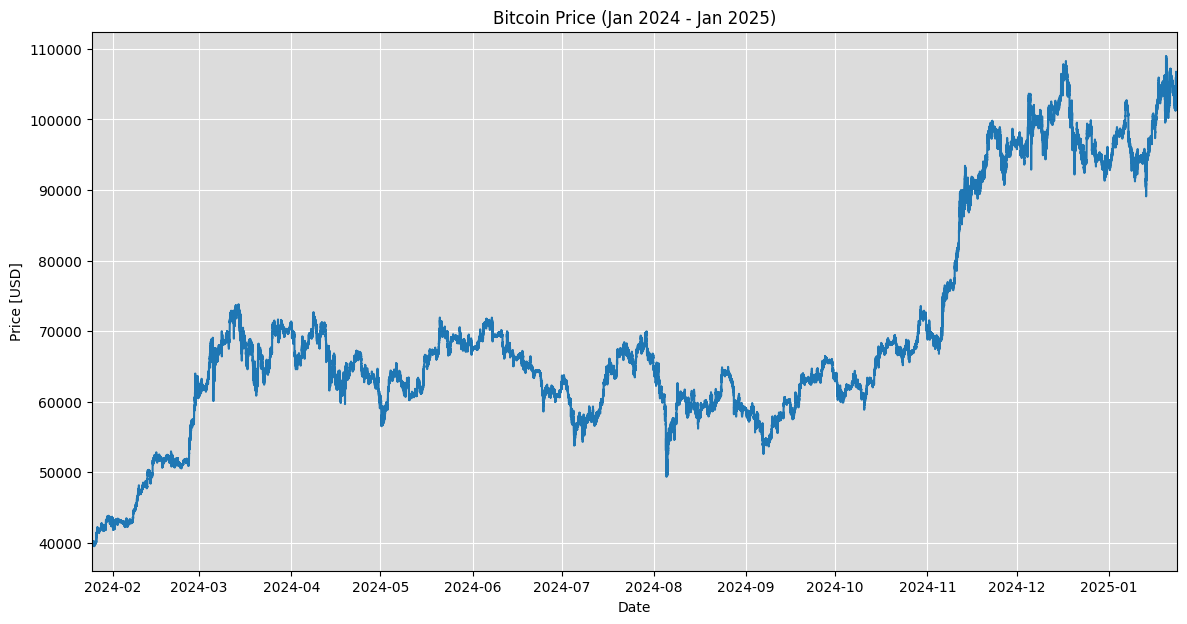

In [11]:
dates = btc_price_data_1_year.index
prices_close_btc = btc_price_data_1_year.close
title_btc = 'Bitcoin Price (Jan 2024 - Jan 2025)'

labels = ['Date', 'Price [USD]']

plot_market_data(dates, prices_close_btc, labels, title_btc)

In [12]:
# Configure the display settings of pandas so that all columns of a DataFrame are shown when printed.
pd.set_option('display.max_columns', None)

## 5. Feature Engineering

### 5.1. Calculate Technical Indicators

In [13]:
def add_technical_indicators(df):
    # Copy the dataframe to avoid modifying the original
    df = df.copy()
    
    # Basic price indicators
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close']/df['close'].shift(1))
    
    # Volume indicators
    df['volume_ma'] = df['volume'].rolling(window=24).mean()  # 24-hour moving average
    df['volume_std'] = df['volume'].rolling(window=24).std()
    
    # Trend indicators
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    df['ema_20'] = df['close'].ewm(span=20).mean()
    
    # RSI
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    
    # MACD
    macd = ta.trend.MACD(df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(df['close'])
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    df['bb_mid'] = bollinger.bollinger_mavg()

    # Average True Range (ATR)
    df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close']).average_true_range()
    
    # On-Balance Volume (OBV)
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
    
    return df

In [14]:
btc_price_data_1_year = add_technical_indicators(btc_price_data_1_year)

### 5.2. Add Time-Based Features

For time-based features like **hour** and **day_of_week**, we can use **cyclical encoding**. This ensures that values like 23:00 and 00:00 are considered "close" to each other, rather than being far apart numerically.

In [15]:
def add_temporal_features(df):
    df = df.copy()
    
    # Extract time components
    # df['hour'] = df.index.hour
    # df['day_of_week'] = df.index.weekday
    # df['day_of_month'] = df.index.day
    # df['month'] = df.index.month
    
    # Create cyclical features for time components
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)  # Hour sin encoding
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)  # Hour cos encoding
    df['day_of_week_sin'] = np.sin(2 * np.pi * df.index.weekday / 7)  # Weekday sin encoding
    df['day_of_week_cos'] = np.cos(2 * np.pi * df.index.weekday / 7)  # Weekday cos encoding
    
    return df

In [16]:
btc_price_data_1_year = add_temporal_features(btc_price_data_1_year)

### 5.3. Seasonality and Trends

#### 5.3.1. STL (Seasonal-Trend decomposition using LOESS)

**STL** stands for **Seasonal-Trend decomposition using LOESS**. It's a robust statistical method used to decompose a time series into three components:

1. **Seasonal Component**: Represents the repeating pattern in the data over a fixed period (e.g., daily, weekly, monthly).
2. **Trend Component**: Captures the long-term progression in the data, showing an overall increase, decrease, or stability over time.
3. **Remainder/Residual Component**: Represents the part of the data that cannot be attributed to either seasonality or trend, often considered as noise.

**Key Features of STL**
- **Flexible**: Allows decomposition of time series with any type of seasonal pattern, not limited to a fixed frequency.
- **Robust**: Resistant to outliers in the data.
- **Local Regression (LOESS)**: Uses locally weighted regression to smooth the data during decomposition.

**Applications**
- **Forecasting**: By isolating the trend and seasonal components, forecasting models can be more accurate.
- **Anomaly Detection**: The remainder component helps identify unusual spikes or dips.
- **Visualization**: Simplifies understanding of the data by breaking it into interpretable parts.

In [17]:
# Apply STL decomposition
stl = STL(btc_price_data_1_year['close'], robust=True, period = 24)  # period=24 for daily seasonality in hourly data
result = stl.fit()

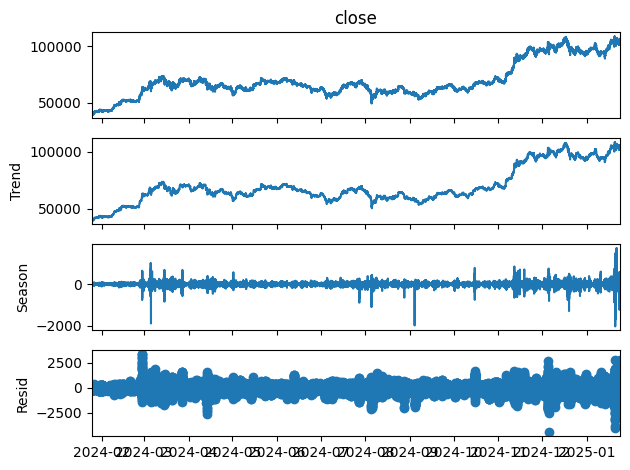

In [18]:
# Extract components
btc_price_data_1_year['trend'] = result.trend
btc_price_data_1_year['seasonal'] = result.seasonal
# btc_price_data_1_year['residual'] = result.resid

# Plot the decomposition
result.plot()
plt.show()

In [19]:
# 1.Rolling Statistics - Rolling mean and standard deviation of each component.
btc_price_data_1_year['trend_rolling_mean'] = btc_price_data_1_year['trend'].rolling(window=24).mean()
btc_price_data_1_year['trend_rolling_std'] = btc_price_data_1_year['trend'].rolling(window=24).std()
# btc_price_data_1_year['residual_rolling_std'] = btc_price_data_1_year['residual'].rolling(window=24).std()

# 2.Differences - Calculate the difference between close price and its trend or seasonality
btc_price_data_1_year['close_trend_diff'] = btc_price_data_1_year['close'] - btc_price_data_1_year['trend']
btc_price_data_1_year['close_seasonal_diff'] = btc_price_data_1_year['close'] - btc_price_data_1_year['seasonal']

#### 5.3.2. Rolling Statistics

Rolling mean and standard deviation help capture local trends and volatility.

In [20]:
# Rolling windows in hours
windows = [3, 6, 24]

In [21]:
for window in windows:
    # Rolling statistics for 'close' price
    btc_price_data_1_year[f'close_roll_mean_{window}'] = btc_price_data_1_year['close'].rolling(window=window).mean()
    btc_price_data_1_year[f'close_roll_std_{window}'] = btc_price_data_1_year['close'].rolling(window=window).std()
    
    # Volume-based rolling statistics
    btc_price_data_1_year[f'volume_roll_mean_{window}'] = btc_price_data_1_year['volume'].rolling(window=window).mean()
    btc_price_data_1_year[f'volume_roll_std_{window}'] = btc_price_data_1_year['volume'].rolling(window=window).std()

    # Get relationships between price and volume changes.
    btc_price_data_1_year[f'close_volume_interaction_{window}'] = btc_price_data_1_year[f'close_roll_mean_{window}'] * btc_price_data_1_year[f'volume_roll_mean_{window}']


### 5.4. Autocorrelation

Autocorrelation in time series refers to the correlation of a time series with a lagged version of itself. It measures how past values of the series influence current values. Understanding autocorrelation can help identify patterns, trends, and periodicity in time-series data.

##### Why Autocorrelation Matters
- **Pattern Detection**: Helps identify repeating patterns or seasonality.
- **Modeling Assumptions**: Many models (like ARIMA) assume specific autocorrelation structures.
- **Feature Engineering**: Insights from autocorrelation can guide the creation of lag-based features for machine learning models.

##### Types of Autocorrelation
1. **Positive Autocorrelation**: High values follow high values, and low values follow low values.
2. **Negative Autocorrelation**: High values follow low values, and vice versa.
3. **No Autocorrelation**: Values are independent of each other.

##### How to Measure Autocorrelation
The **autocorrelation function (ACF)** and the **partial autocorrelation function (PACF)** are two common tools:

###### 1. **Autocorrelation Function (ACF)**
- Measures the correlation between the time series and its lagged values.
- Useful for identifying the overall pattern of dependence at different lags.

###### 2. **Partial Autocorrelation Function (PACF)**
- Measures the correlation between the time series and its lagged values after removing the influence of shorter lags.
- Useful for determining the direct relationship between a value and a specific lag.


#### 5.4.1. Autocorrelation Function (ACF)

Set the count of the **lags** that will be considered during the Autocorrelation anylysis:

In [22]:
# We use the last day (24 hours) for the autocorrelation analysis
lags = 24

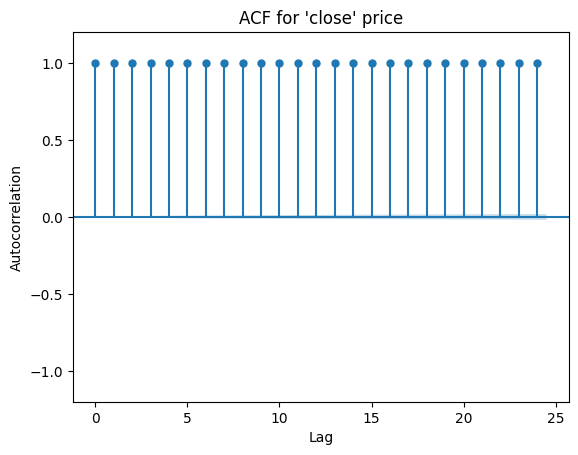

In [23]:
plot_acf(btc_price_data_1_year.close, lags = lags)
plt.ylim(-1.2, 1.2)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF for \'close\' price')
plt.show()

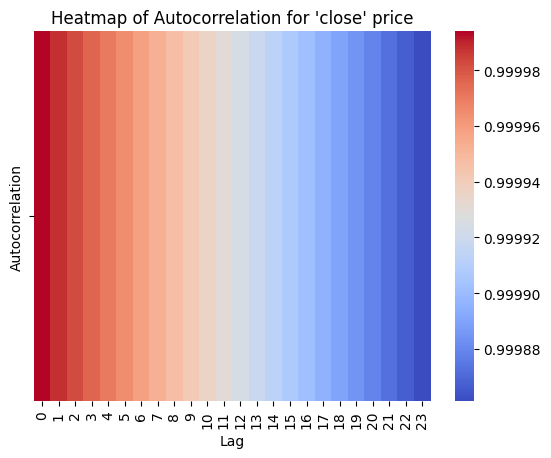

In [24]:
autocorr = [btc_price_data_1_year['close'].autocorr(lag) for lag in range(1, lags+1)]
sns.heatmap(pd.DataFrame(autocorr, columns=["Autocorrelation"]).T, annot=False, cmap="coolwarm")
plt.xlabel('Lag')
plt.title('Heatmap of Autocorrelation for \'close\' price')
plt.show()

Because the **autocorrelation** is very large we use **partial autocorrelation**.

#### 5.4.2. Partial Autocorrelation Function (PACF)

The **Partial Autocorrelation Function (PACF)** measures the partial correlation of a stationary time series with its own lagged values, accounting for the influence of intermediate lags. Unlike the **Autocorrelation Function (ACF)**, which considers all previous lags, the PACF isolates the direct relationship between a variable and its lags.

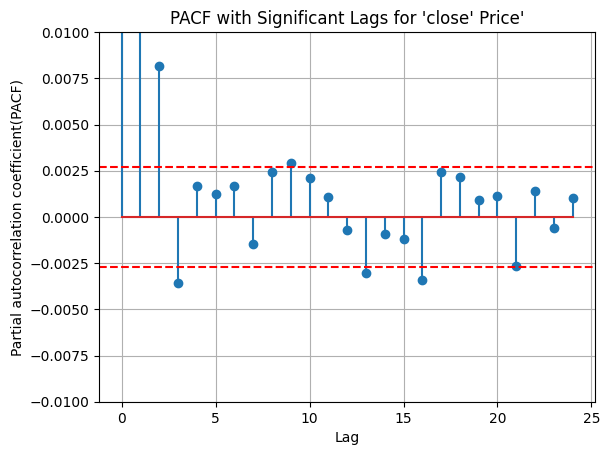

Significant Lags: [ 0  1  2  3  9 13 16]


In [25]:
# Calculate PACF
pacf_values = pacf(btc_price_data_1_year['close'], nlags=lags)

# Calculate the confidence interval
conf_int = 1.96 / np.sqrt(len(btc_price_data_1_year['close']))  # The 95% confidence interval

# Get significant lags (values outside the confidence interval)
significant_lags = np.where(np.abs(pacf_values) > conf_int)[0]

# Plot PACF with significant lags marked
plt.stem(pacf_values)

plt.axhline(y=conf_int, color='r', linestyle='--')
plt.axhline(y=-conf_int, color='r', linestyle='--')
plt.ylim(-0.010, 0.010)

plt.grid()

plt.xlabel('Lag')
plt.ylabel('Partial autocorrelation coefficient(PACF)')
plt.title("PACF with Significant Lags for \'close\' Price'")
plt.show()

# Print the significant lags
print("Significant Lags:", significant_lags)

**Significant lags**: Spikes that are outside the area between the two red lines are **statistically significant** at the 95% confidence level.

Correlation coefficients that are between the two red lines are **insignificant** for the model. In this area the **p-value** is too small. Correlations in this area may well be random.

In [26]:
# Remove the autocorrelation with itself (the '0'-th lag)
significant_lags = significant_lags[1:] if significant_lags[0] == 0 else significant_lags
print("Significant Lags:", significant_lags)

Significant Lags: [ 1  2  3  9 13 16]


In [27]:
# Create lag features (past values as features)
def create_lag_features(df, lags = []):
    """
    Create lag features (past values as features)
    """
    # Create a copy of the DataFrame
    df_copy = df.copy(deep=True)
    
    for lag in lags:
        df_copy[f'lag_{lag}'] = df_copy['close'].shift(lag)
        
        # Create lagged values of the trend and seasonal
        df_copy[f'trend_lag_{lag}'] = df_copy['trend'].shift(lag)
        df_copy[f'seasonal_lag_{lag}'] = df_copy['seasonal'].shift(lag)

        # Create lagged values of the difference between close price and its trend or seasonality
        df_copy[f'close_trend_diff_lag_{lag}'] = df_copy['close_trend_diff'].shift(lag)
        df_copy[f'close_seasonal_diff_lag_{lag}'] = df_copy['close_seasonal_diff'].shift(lag)
        
    #df.dropna(inplace=True)
    return df_copy

In [28]:
btc_price_data_1_year = create_lag_features(btc_price_data_1_year, significant_lags)

### 5.5. Calculate Target Variable

The **target** variable will be derived from the calculated **future returns**. The values of this variable are used as **buy/sell signals** for the traiding strategy. 

There will be 2 target values:
* 0  - price falls
* 1  - price rises

In [29]:
def create_target(df, forecast_horizon=1):
    df = df.copy()
    
    # Calculate future returns
    df['future_return'] = df['close'].shift(-forecast_horizon) / df['close'] - 1
    
    # Create binary target (1 for price up, 0 for price down)
    df['target'] = (df['future_return'] > 0).astype(int)

    print(df['target'].value_counts())
    
    return df

In [30]:
btc_price_data_1_year = create_target(btc_price_data_1_year, 1)

target
0    264778
1    262407
Name: count, dtype: int64


### 5.6. Clean up the Data

There are some rows in the dataset that have a `NaN` values (e.g.: `future_return`, `RSI`, `SMA`, some `lag`-columns) due to the feature engineering process. We will delete these rows to clean up the dataset.

In [31]:
btc_price_data_1_year = btc_price_data_1_year.dropna()

In [32]:
btc_price_data_1_year.shape

(527135, 78)

In [33]:
btc_price_data_1_year.isnull().sum()

open                          0
high                          0
low                           0
close                         0
volume                        0
                             ..
seasonal_lag_16               0
close_trend_diff_lag_16       0
close_seasonal_diff_lag_16    0
future_return                 0
target                        0
Length: 78, dtype: int64

In [34]:
btc_price_data_1_year.dtypes

open                          float64
high                          float64
low                           float64
close                         float64
volume                        float64
                               ...   
seasonal_lag_16               float64
close_trend_diff_lag_16       float64
close_seasonal_diff_lag_16    float64
future_return                 float64
target                          int64
Length: 78, dtype: object

In [35]:
btc_price_data_1_year.columns

Index(['open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns',
       'volume_ma', 'volume_std', 'sma_20', 'sma_50', 'ema_20', 'rsi', 'macd',
       'macd_signal', 'macd_diff', 'bb_high', 'bb_low', 'bb_mid', 'atr', 'obv',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'trend',
       'seasonal', 'trend_rolling_mean', 'trend_rolling_std',
       'close_trend_diff', 'close_seasonal_diff', 'close_roll_mean_3',
       'close_roll_std_3', 'volume_roll_mean_3', 'volume_roll_std_3',
       'close_volume_interaction_3', 'close_roll_mean_6', 'close_roll_std_6',
       'volume_roll_mean_6', 'volume_roll_std_6', 'close_volume_interaction_6',
       'close_roll_mean_24', 'close_roll_std_24', 'volume_roll_mean_24',
       'volume_roll_std_24', 'close_volume_interaction_24', 'lag_1',
       'trend_lag_1', 'seasonal_lag_1', 'close_trend_diff_lag_1',
       'close_seasonal_diff_lag_1', 'lag_2', 'trend_lag_2', 'seasonal_lag_2',
       'close_trend_diff_lag_2', 'close_s

In [36]:
btc_price_data_1_year.describe().T

,count,mean,std,min,25%,50%,75%,max
open,527135.0,69425.976425,15427.345308,39503.000000,60758.015000,65737.470000,70695.285000,108768.040000
high,527135.0,69486.950357,15443.738156,39544.660000,60804.915000,65784.550000,70751.770000,109358.010000
low,527135.0,69456.408885,15435.508352,39533.470000,60781.345000,65761.070000,70724.370000,108954.900000
close,527135.0,69456.717024,15435.521274,39533.480000,60781.680000,65760.970000,70723.730000,108951.030000
volume,527135.0,8.978932,16.369773,0.000166,1.669580,3.955783,9.717191,1047.117525
...,...,...,...,...,...,...,...,...
seasonal_lag_16,527135.0,-0.000234,48.391360,-2032.181975,-17.212649,-0.013868,17.401066,1736.254698
close_trend_diff_lag_16,527135.0,-2.547705,127.002201,-4564.922091,-36.026786,-0.352064,34.820613,3261.860645
close_seasonal_diff_lag_16,527135.0,69454.775152,15435.212196,39520.293074,60782.771595,65759.137349,70722.836484,109125.228155
future_return,527135.0,0.000002,0.000748,-0.036938,-0.000320,0.000000,0.000324,0.027998


### 5.7. Save Dataset

Save the preprocessed dataset to a csv file.

In [37]:
def save_data(df, filename='bitcoin_historical_data.csv'):
    # Save file
    df.to_csv(filename)
    
    print(f"Data saved to: {filename}")

In [38]:
# Save the preprocessed dataset to a csv file
save_data(btc_price_data_1_year, filename = 'data/btc_price_data_1_year_prepocessed.csv')

Data saved to: data/btc_price_data_1_year_prepocessed.csv


## 6. Data Preprocessing

Load the prepared dataset:

In [39]:
btc_price_data_1_year = pd.read_csv("data/btc_price_data_1_year_prepocessed.csv")
btc_price_data_1_year.set_index('timestamp', inplace=True, drop = True)
btc_price_data_1_year

,open,high,low,close,volume,returns,log_returns,volume_ma,volume_std,sma_20,sma_50,ema_20,rsi,macd,macd_signal,macd_diff,bb_high,bb_low,bb_mid,atr,obv,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,trend,seasonal,trend_rolling_mean,trend_rolling_std,close_trend_diff,close_seasonal_diff,close_roll_mean_3,close_roll_std_3,volume_roll_mean_3,volume_roll_std_3,close_volume_interaction_3,close_roll_mean_6,close_roll_std_6,volume_roll_mean_6,volume_roll_std_6,close_volume_interaction_6,close_roll_mean_24,close_roll_std_24,volume_roll_mean_24,volume_roll_std_24,close_volume_interaction_24,lag_1,trend_lag_1,seasonal_lag_1,close_trend_diff_lag_1,close_seasonal_diff_lag_1,lag_2,trend_lag_2,seasonal_lag_2,close_trend_diff_lag_2,close_seasonal_diff_lag_2,lag_3,trend_lag_3,seasonal_lag_3,close_trend_diff_lag_3,close_seasonal_diff_lag_3,lag_9,trend_lag_9,seasonal_lag_9,close_trend_diff_lag_9,close_seasonal_diff_lag_9,lag_13,trend_lag_13,seasonal_lag_13,close_trend_diff_lag_13,close_seasonal_diff_lag_13,lag_16,trend_lag_16,seasonal_lag_16,close_trend_diff_lag_16,close_seasonal_diff_lag_16,future_return,target
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-25 00:49:00,40096.06,40117.78,40096.06,40109.60,10.527911,3.411818e-04,3.411237e-04,9.599183,6.414985,40080.4245,40063.4206,40090.375072,56.858930,17.426433,16.994612,0.431821,40176.685915,39984.163085,40080.4245,13.980711,-12.766038,0.000000,1.000000,0.433884,-0.900969,40114.220400,-7.645490,40078.040532,21.292628,-4.620400,40117.245490,40100.623333,7.776994,6.388110,3.601780,256167.191051,40107.061667,19.183734,9.010085,4.904713,361368.018407,40069.088750,51.836342,9.599183,6.414985,384630.523234,40095.92,40111.603889,-8.272177,-15.683889,40104.192177,40096.35,40108.723855,-10.136533,-12.373855,40106.486533,40107.20,40105.600852,-7.333473,1.599148,40114.533473,40143.04,40083.855182,27.264336,59.184818,40115.775664,40050.06,40070.192128,3.364993,-20.132128,40046.695007,40022.89,40061.968191,3.547758,-39.078191,40019.342242,2.592895e-04,1
2024-01-25 00:50:00,40099.42,40120.00,40109.59,40120.00,4.440333,2.592895e-04,2.592559e-04,8.592098,5.053382,40084.7810,40064.7846,40093.213727,59.054379,17.628187,17.121327,0.506860,40179.919329,39989.642671,40084.7810,13.725660,-8.325705,0.000000,1.000000,0.433884,-0.900969,40116.561413,-12.751954,40080.817543,21.804741,3.438587,40132.751954,40108.506667,12.077174,6.313659,3.657131,253231.426606,40103.193333,11.054345,7.147957,3.918131,286655.895293,40073.326667,51.660072,8.592098,5.053382,344313.941524,40109.60,40114.220400,-7.645490,-4.620400,40117.245490,40095.92,40111.603889,-8.272177,-15.683889,40104.192177,40096.35,40108.723855,-10.136533,-12.373855,40106.486533,40128.86,40087.587718,16.391777,41.272282,40112.468223,40045.03,40073.345773,-6.199338,-28.315773,40051.229338,40015.81,40064.501111,5.611222,-48.691111,40010.198778,-4.349452e-04,0
2024-01-25 00:51:00,40102.55,40121.45,40116.87,40102.55,3.447542,-4.349452e-04,-4.350398e-04,8.493151,5.132602,40089.3455,40065.5972,40094.107807,54.081290,16.193342,16.935730,-0.742388,40178.508514,40000.182486,40089.3455,13.072398,-11.773246,0.000000,1.000000,0.433884,-0.900969,40118.620925,-14.907866,40083.635183,22.150278,-16.070925,40117.457866,40110.716667,8.778430,6.138595,3.833533,246223.459350,40105.270000,9.097626,5.477551,2.597781,219678.650631,40077.190833,50.148833,8.493151,5.132602,340381.633086,40120.00,40116.561413,-12.751954,3.438587,40132.751954,40109.60,40114.220400,-7.645490,-4.620400,40117.245490,40095.92,40111.603889,-8.272177,-15.683889,40104.192177,40144.19,40091.349910,11.007855,52.840090,40133.182145,40057.67,40076.691626,-7.452409,-19.021626,40065.122409,40034.50,40067.242085,7.111680,-32.742085,40027.388320,1.780435e-04,1
2024-01-25 00:52:00,40097.26,40113.46,40101.91,40109.69,3.290059,1.780435e-04,1.780277e-04,8.310886,5.239860,40094.0915,40066.9346,40095.599237,55.724252,15.454209,16.639426,-1.185217,40176.737877,40011.445123,40094

### 6.1. One-hot encoding for categorical features

In [40]:
# btc_price_data_1_year = pd.get_dummies(btc_price_data_1_year, columns=['day_of_week', 'day_of_month', 'month'], drop_first=True) # drop_first to avoid multicollinearity

### 6.2. Split the Dataset

The data is split chronologically to avoid data leakage:
- **Training set**: 80% of the data (used for training the model).
- **Validation set**: 10% of the data (used for hyperparameter tuning).
- **Test set**: 10% of the data (used to evaluate final performance).

In [41]:
# Split the dataset into train, validation, and test sets
train_size = 0.8
val_size = 0.1
test_size = 0.1

# Compute split indices
train_idx = int(len(btc_price_data_1_year) * train_size)
val_idx = int(len(btc_price_data_1_year) * (train_size + val_size))

# Split the data
btc_price_data_1_year_train = btc_price_data_1_year[:train_idx]
X_train = btc_price_data_1_year_train.drop('target', axis=1)
y_train = btc_price_data_1_year_train['target']

btc_price_data_1_year_val = btc_price_data_1_year[train_idx:val_idx]
X_val = btc_price_data_1_year_val.drop('target', axis=1)
y_val = btc_price_data_1_year_val['target']

btc_price_data_1_year_test = btc_price_data_1_year[val_idx:]
X_test = btc_price_data_1_year_test.drop('target', axis=1)
y_test = btc_price_data_1_year_test['target']

print(f"Total rows: {len(btc_price_data_1_year)} rows")
print(f"Training set: {len(X_train)} rows")
print(f"Validation set: {len(X_val)} rows")
print(f"Test set: {len(X_test)} rows")

Total rows: 527135 rows
Training set: 421708 rows
Validation set: 52713 rows
Test set: 52714 rows


In [42]:
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(target
 0    211560
 1    210148
 Name: count, dtype: int64,
 target
 0    26566
 1    26147
 Name: count, dtype: int64,
 target
 0    26629
 1    26085
 Name: count, dtype: int64)

In [43]:
def plot_splitted_market_data(dates, prices, labels, title):
    plt.figure(figsize=(14, 7))
    
    ax = plt.gca()
    ax.set_facecolor('gainsboro')
    ax.xaxis.grid(True, color='white')
    ax.yaxis.grid(True, color='white')

    # x_lim_start = dates[0][0]
    # x_lim_end = dates[1][len(dates[1]) - 1]
    # # x_lim_end = dates[len(dates[0]) + len(dates[1]) - 1]
    # # plt.xlim(x_lim_start, x_lim_end)
    # ax.set_xlim(xmin=x_lim_start,xmax=x_lim_end)
    
    plt.plot(dates[0], prices[0], label ='Train Data')
    plt.plot(dates[1], prices[1], label ='Validation Data')
    plt.plot(dates[2], prices[2], label ='Test Data')
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.title(title)
    plt.legend()
    plt.show()

In [44]:
# dates_train = btc_price_data_1_year_train.index
# prices_close_train = btc_price_data_1_year_train.close

# dates_val = btc_price_data_1_year_val.index
# prices_close_val = btc_price_data_1_year_val.close

# dates_test = btc_price_data_1_year_test.index
# prices_close_test = btc_price_data_1_year_test.close

# dates = [dates_train, dates_val, dates_test]
# prices_close_btc = [prices_close_train, prices_close_val, prices_close_test]

# title_btc = 'Data Split (Jan 2024 - Jan 2025)'

# labels = ['Date', 'Price [USD]']

# plot_splitted_market_data(dates, prices_close_btc, labels, title_btc)

### 6.3. Scale Features

A **StandardScaler** is used for scaling the features. There are three steps that are performed:
1. Define the features to be scaled (**numerical columns**).
2. Fit the scaler on the **training set** only.
3. Apply the transformation to training, validation, and test sets.

In [45]:
# Exclude already normalized features like 'hour_sin'/'hour_cos'
features_to_exclude = []
for x in btc_price_data_1_year.columns:
    if x.startswith('day_of_week') or x.startswith('day_of_month') or x.startswith('month') or x.startswith('hour') or x.startswith('target'):
        features_to_exclude.append(x)

# Select the remaining columns
numericel_features_to_scale = [col for col in btc_price_data_1_year.columns if col not in features_to_exclude]

# Initialize the MinMaxScaler
scaler = StandardScaler()

# Scale selected features
X_train_scaled = X_train.copy() 
X_val_scaled = X_val.copy() 
X_test_scaled = X_test.copy()

# Fit the scaler ONLY on the training set and transform all sets
X_train_scaled[numericel_features_to_scale] = scaler.fit_transform(X_train[numericel_features_to_scale])
X_val_scaled[numericel_features_to_scale] = scaler.transform(X_val[numericel_features_to_scale])
X_test_scaled[numericel_features_to_scale] = scaler.transform(X_test[numericel_features_to_scale])

In [46]:
X_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
open,421708.0,-3.662065e-15,1.000001,-3.177351,-0.437242,0.155325,0.682338,3.736956
high,421708.0,1.518312e-15,1.000001,-3.176112,-0.436733,0.155641,0.682258,3.745607
low,421708.0,3.347188e-15,1.000001,-3.175406,-0.436787,0.155526,0.682257,3.742514
close,421708.0,-3.209159e-15,1.000001,-3.175430,-0.436823,0.155542,0.682252,3.742622
volume,421708.0,-2.695866e-18,1.000001,-0.531842,-0.434556,-0.300464,0.035005,63.425561
...,...,...,...,...,...,...,...,...
trend_lag_16,421708.0,-2.251588e-15,1.000001,-3.163351,-0.437930,0.155870,0.682622,3.625630
seasonal_lag_16,421708.0,-1.364782e-17,1.000001,-50.688085,-0.384378,-0.000554,0.387973,26.166596
close_trend_diff_lag_16,421708.0,1.617520e-18,1.000001,-23.986912,-0.283235,0.014007,0.309665,31.030179
close_seasonal_diff_lag_16,421708.0,-2.557838e-15,1.000001,-3.177155,-0.436863,0.155717,0.682618,3.759726


### 6.4. Reshape Data for LSTM

LSTMs require input data in the shape of `(samples, sequence_length, num_features)`. For time series data, convert the flat features into sequences.

In [47]:
def create_sequences(X, y, timesteps):
    # Convert inputs to numpy arrays if they're not already
    if hasattr(X, 'values'):
        X_array = X.values
    else:
        X_array = np.array(X)
    if hasattr(y, 'values'):
        y_array = y.values
    else:
        y_array = np.array(y)
    
    # Ensure X_array has shape (samples, num_features)
    # If not, adjust (for example, if it is transposed)
    if X_array.shape[0] < X_array.shape[1]:
        X_array = X_array.T

    # Create the sliding window view along the time axis (axis=0)
    X_seq = np.lib.stride_tricks.sliding_window_view(X_array, window_shape=timesteps, axis=0)
    # X_seq is expected to have shape (samples - timesteps + 1, timesteps, num_features)
    
    # Sometimes the window axis might appear in a different position,
    # so check if the last dimension matches the number of features.
    if X_seq.shape[-1] != X_array.shape[1]:
        # If not, swap the last two axes
        X_seq = np.swapaxes(X_seq, -1, -2)

    # Since the original loop created windows for indices timesteps to len(X)-1,
    # we take all but the last sliding window to match the target length.
    X_seq = X_seq[:-1]
    
    # The corresponding target values from y start at index `timesteps`
    y_seq = y_array[timesteps:]

    # Ensure both arrays have a numeric dtype (e.g., float32)
    X_seq = X_seq.astype(np.float32)
    y_seq = y_seq.astype(np.float32)
    
    return X_seq, y_seq

In [48]:
# Define the number of timesteps (sequence length) for LSTM
TIMESTEPS = 12 # Look at the past 12 hours
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, TIMESTEPS)
print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}")

X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, TIMESTEPS)
print(f"X_val_seq shape: {X_val_seq.shape}, y_val_seq shape: {y_val_seq.shape}")

X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, TIMESTEPS)
print(f"X_test_seq shape: {X_test_seq.shape}, y_test_seq shape: {y_test_seq.shape}")

X_train_seq shape: (421696, 12, 77), y_train_seq shape: (421696,)
X_val_seq shape: (52701, 12, 77), y_val_seq shape: (52701,)
X_test_seq shape: (52702, 12, 77), y_test_seq shape: (52702,)


## 7. Define Model Architecture

### 7.1. Model Definition

We will create an advanced CNN-LSTM model architecture specifically designed for our data.

The model architecture includes:
   - Multiple CNN layers to capture patterns in technical indicators [1]
   - Batch normalization to stabilize training
   - LSTM layers to capture temporal dependencies [2]
   - Dropout for regularization
   - Dense layers for final prediction

In [49]:
# Attention Mechanism to improve feature importance weighting
@keras.saving.register_keras_serializable()
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def call(self, inputs):
        attention_scores = tf.nn.softmax(inputs, axis=1)  # Compute attention weights
        return tf.reduce_sum(inputs * attention_scores, axis=1)  # Weighted sum

In [50]:
def create_cnn_lstm_model(input_shape, params):
    """
    Creates a CNN-LSTM hybrid model optimized for cryptocurrency price prediction.
    
    Parameters:
    input_shape: Tuple of (sequence_length, n_features)
    params: variables used from the model
    """
    dropout_rate = params['dropout_rate']
    lstm_units_1 = params['lstm_units_1']
    lstm_units_2 = params['lstm_units_2']
    lstm_units_3 = params['lstm_units_3']
    cnn_filters_1 = params['cnn_filters_1']
    cnn_filters_2 = params['cnn_filters_2']
    cnn_kernel_size = params['cnn_kernel_size']
    cnn_dropout = params['cnn_dropout']
    l2_reg = params['l2_reg']

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)
    
    # First CNN block - captures local patterns in technical indicators
    x = tf.keras.layers.Conv1D(filters=cnn_filters_1, kernel_size=cnn_kernel_size, strides=2, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(cnn_dropout)(x) 
    
    # Second CNN block - captures more complex patterns
    x = tf.keras.layers.Conv1D(filters=cnn_filters_2, kernel_size=cnn_kernel_size, strides=2, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(cnn_dropout)(x)
    
    # LSTM layers - capture temporal dependencies
    x = tf.keras.layers.LSTM(lstm_units_1, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(lstm_units_2, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(lstm_units_3, return_sequences=True)(x)

    # Attention Layer
    x = Attention()(x)
    
    # Dense layers with L2 regularization
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)  # Dropout for generalization
    
    # Output layer - binary classification
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Create and compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

### 7.2. Evaluate the Model

#### Visualize the training history and model performance

In [51]:
def plot_training_history(history):
    """
    Visualizes the model's training history, showing how metrics evolved over epochs.
    """
    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot training & validation accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

#### Analyze the model's predictions 

In [52]:
def get_optimal_treshold(y_test, y_pred_proba):
    # `y_test` are the true labels and `y_pred_probs` are the predicted probabilities from the model
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # Find the optimal threshold (point with the highest TPR - FPR)
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [53]:
def analyze_predictions(model, X_test, y_test, threshold=0.5):
    """
    Comprehensive analysis of model predictions including confusion matrix,
    ROC curve, and detailed metrics.
    """
    # Get predictions
    y_pred_proba = model.predict(X_test)

    if threshold == 0.5:
        # get optimal treshold
        threshold = get_optimal_treshold(y_test, y_pred_proba)

    print("current threshold: ", threshold)
    y_pred = (y_pred_proba >= threshold).astype(int)
        
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    ax2.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic')
    ax2.legend(loc="lower right")
    
    # 3. Prediction Distribution
    sns.histplot(y_pred_proba, bins=50, ax=ax3)
    ax3.axvline(threshold, color='r', linestyle='--', 
                label=f'Threshold ({threshold})')
    ax3.set_title('Distribution of Prediction Probabilities')
    ax3.set_xlabel('Predicted Probability')
    ax3.set_ylabel('Count')
    ax3.legend()
    
    # 4. Classification Report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    ax4.axis('off')
    ax4.table(cellText=report_df.round(3).values,
              rowLabels=report_df.index,
              colLabels=report_df.columns,
              cellLoc='center',
              loc='center')
    ax4.set_title('Classification Report')
    
    plt.tight_layout()
    plt.show()
    
    return y_pred_proba, y_pred

#### Analyze prediction errors and identify patterns

In [54]:
def analyze_prediction_errors(model, X_test, y_test, processed_df, scaler, threshold=0.5):
    """
    Analyzes when and why the model makes incorrect predictions.
    """
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Create error analysis DataFrame
    error_analysis = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred.flatten(),
        'Probability': y_pred_proba.flatten(),
        'Error': y_test != y_pred.flatten()
    })
    
    # Create visualizations for error analysis
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Probability distribution for correct vs incorrect predictions
    sns.kdeplot(data=error_analysis, x='Probability', hue='Error', ax=ax1)
    ax1.set_title('Prediction Probability Distribution\nCorrect vs Incorrect Predictions')
    
    # 2. Confusion matrix with percentages
    cm_percent = confusion_matrix(y_test, y_pred, normalize='true')
    sns.heatmap(cm_percent, annot=True, fmt='.2%', ax=ax2)
    ax2.set_title('Confusion Matrix (Percentages)')
    
    plt.tight_layout()
    plt.show()
    
    return error_analysis

#### Evaluate the model's performance over different time horizons

In [55]:
def evaluate_prediction_horizons(model, X_test, y_test, processed_df):
    """
    Evaluates how the model's performance varies over different prediction horizons.
    """
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Create DataFrames for analysis
    predictions_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred.flatten(),
        'Timestamp': processed_df.index[-len(y_test):]
    })
    
    # Calculate rolling accuracy
    window_sizes = [24, 72, 168]  # 1 day, 3 days, 1 week
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot rolling accuracy for different windows
    for window in window_sizes:
        rolling_acc = (
            (predictions_df['Actual'] == (predictions_df['Predicted'] > 0.5))
            .rolling(window)
            .mean()
        )
        rolling_acc.plot(ax=ax1, label=f'{window}h Rolling Accuracy')
    
    ax1.set_title('Rolling Accuracy Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot cumulative accuracy
    cumulative_acc = (
        (predictions_df['Actual'] == (predictions_df['Predicted'] > 0.5))
        .cumsum() / range(1, len(predictions_df) + 1)
    )
    cumulative_acc.plot(ax=ax2)
    ax2.set_title('Cumulative Accuracy Over Time')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Cumulative Accuracy')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return predictions_df

#### Start Complete Analysis

In [56]:
def perform_complete_analysis(model, X_test, y_test, processed_df, history, scaler):
    """
    Performs a complete analysis of the model's performance.
    """
    print("1. Analyzing training history...")
    plot_training_history(history)
    
    print("\n2. Analyzing predictions...")
    y_pred_proba, y_pred = analyze_predictions(model, X_test, y_test)
    
    print("\n3. Analyzing prediction errors...")
    error_analysis = analyze_prediction_errors(model, X_test, y_test, processed_df, scaler)
    
    print("\n4. Evaluating prediction horizons...")
    predictions_df = evaluate_prediction_horizons(model, X_test, y_test, processed_df)
    
    return {
        'predictions': predictions_df,
        'error_analysis': error_analysis,
        'probabilities': y_pred_proba,
        'predicted_classes': y_pred
    }

## 8. Evaluate the best model

### 8.1. Model Hyperparameter Tuning

The **CNN-LSTM** model was trained with the Bitcoin Train data. The training runs can be viewed in [Model-Fine-Tunning](2.Model-Fine-Tuning.ipynb).

The hyperparameters were optimized with the help of **Optuna**. 20 tests with 15 epochs were carried out. 

At the end, the model was trained with the best parameters and the results evaluated.

### 8.2. Evaluation of the best model

The best model with the lowest **val_loss** is used for the time series forecast.

#### 8.2.1. Model Training

The parameters from the best trial with Optuna are used for the training.

In [57]:
best_params = {
    'learning_rate': 0.002002107904206037, 
    'dropout_rate': 0.42405283731515464, 
    'batch_size': 128, 
    'lstm_units_1': 256, 
    'lstm_units_2': 128, 
    'lstm_units_3': 128, 
    'cnn_filters_1': 32, 
    'cnn_filters_2': 64, 
    'cnn_kernel_size': 5, 
    'cnn_dropout': 0.2519697330190695, 
    'l2_reg': 0.0002621439642328245
}

In [58]:
def train_model(X_train, y_train, X_val, y_val, input_shape, filepath, params, epochs=100):
    """
    Trains the CNN-LSTM model with proper callbacks and monitoring.
    """
    # Create model with sampled hyperparameters
    model = create_cnn_lstm_model(input_shape, params)

    model.summary()
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    # Define callbacks
    callbacks = [
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        # Reduce learning rate when progress stalls
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-5
        ),
       
        # Model checkpoint to save best model
        tf.keras.callbacks.ModelCheckpoint(
            filepath,
            monitor='val_loss',
            save_best_only=True
        )
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size= params['batch_size'],
        callbacks=callbacks,
        verbose=1
    )

    return model, history

In [59]:
# Define the count of epochs for the training
epochs = 100

# filepath for the best model
filepath = 'models/best_model_lstm_forecasting.h5.keras'

# Set model type
model_type = 'LSTM'

I0000 00:00:1740668409.355754    6813 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2242 MB memory:  -> device: 0, name: Quadro T2000, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 77)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 6, 32)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 64)          │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 256)         │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,769 (2.63 MB)

 Trainable params: 688,577 (2.63 MB)

 Non-trainable params: 192 (768.00 B)

2025-02-27 16:00:11.727645: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1558588416 exceeds 10% of free system memory.
2025-02-27 16:00:12.677373: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1558588416 exceeds 10% of free system memory.


Epoch 1/100


I0000 00:00:1740668417.558847    6904 cuda_dnn.cc:529] Loaded cuDNN version 90300


3295/3295 ━━━━━━━━━━━━━━━━━━━━ 137s 39ms/step - accuracy: 0.6063 - auc: 0.6471 - loss: 0.6593 - precision: 0.6049 - recall: 0.5981 - val_accuracy: 0.6176 - val_auc: 0.6908 - val_loss: 0.6485 - val_precision: 0.5851 - val_recall: 0.7876 - learning_rate: 0.0020
Epoch 2/100
3295/3295 ━━━━━━━━━━━━━━━━━━━━ 129s 39ms/step - accuracy: 0.6832 - auc: 0.7457 - loss: 0.5976 - precision: 0.6838 - recall: 0.6775 - val_accuracy: 0.6602 - val_auc: 0.7151 - val_loss: 0.6217 - val_precision: 0.6775 - val_recall: 0.6009 - learning_rate: 0.0020
Epoch 3/100
3295/3295 ━━━━━━━━━━━━━━━━━━━━ 127s 39ms/step - accuracy: 0.6934 - auc: 0.7590 - loss: 0.5857 - precision: 0.6919 - recall: 0.6939 - val_accuracy: 0.6558 - val_auc: 0.7243 - val_loss: 0.6189 - val_precision: 0.6917 - val_recall: 0.5521 - learning_rate: 0.0020
Epoch 4/100
3295/3295 ━━━━━━━━━━━━━━━━━━━━ 119s 36ms/step - accuracy: 0.6973 - auc: 0.7636 - loss: 0.5818 - precision: 0.6990 - recall: 0.6896 - val_accuracy: 0.6650 - val_auc: 0.7248 - val_loss: 

2025-02-27 18:06:34.362210: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1558588416 exceeds 10% of free system memory.
2025-02-27 18:06:35.550613: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1558588416 exceeds 10% of free system memory.


13178/13178 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step 
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

train_classification_report_LSTM:                precision    recall  f1-score   support

         0.0       0.74      0.75      0.74    211554
         1.0       0.74      0.74      0.74    210142

    accuracy                           0.74    421696
   macro avg       0.74      0.74      0.74    421696
weighted avg       0.74      0.74      0.74    421696


test_classification_report_LSTM:                precision    recall  f1-score   support

         0.0       0.68      0.71      0.69     26620
         1.0       0.69      0.66      0.68     26082

    accuracy                           0.69     52702
   macro avg       0.69      0.69      0.69     52702
weighted avg       0.69      0.69      0.69     52702

1. Analyzing training history...


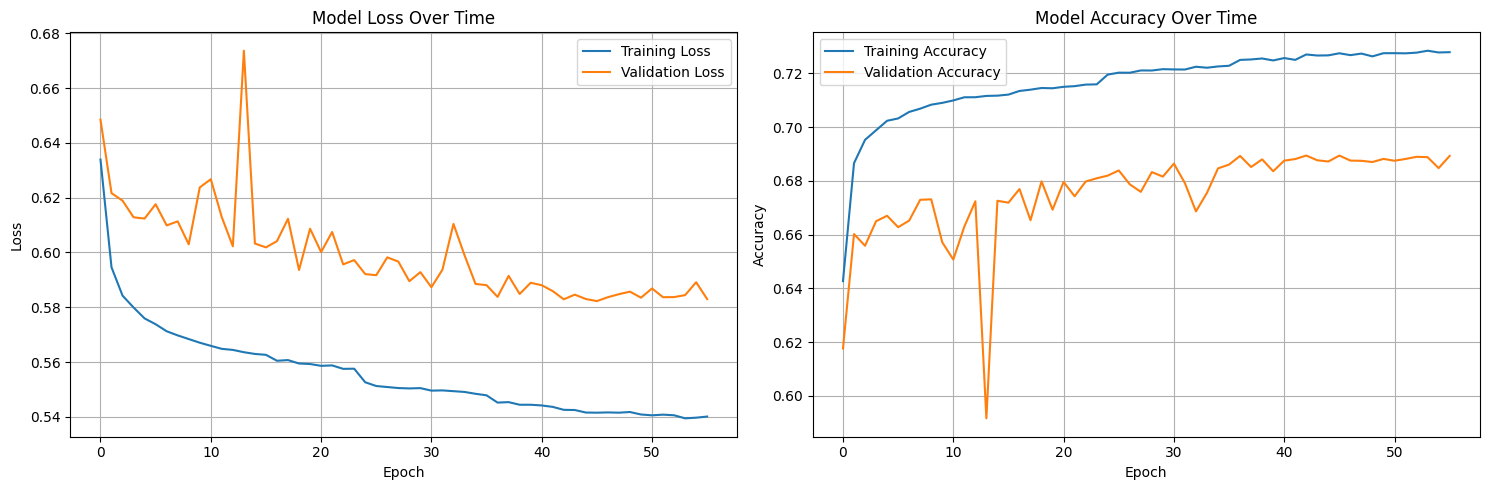


2. Analyzing predictions...
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
current threshold:  0.46964747


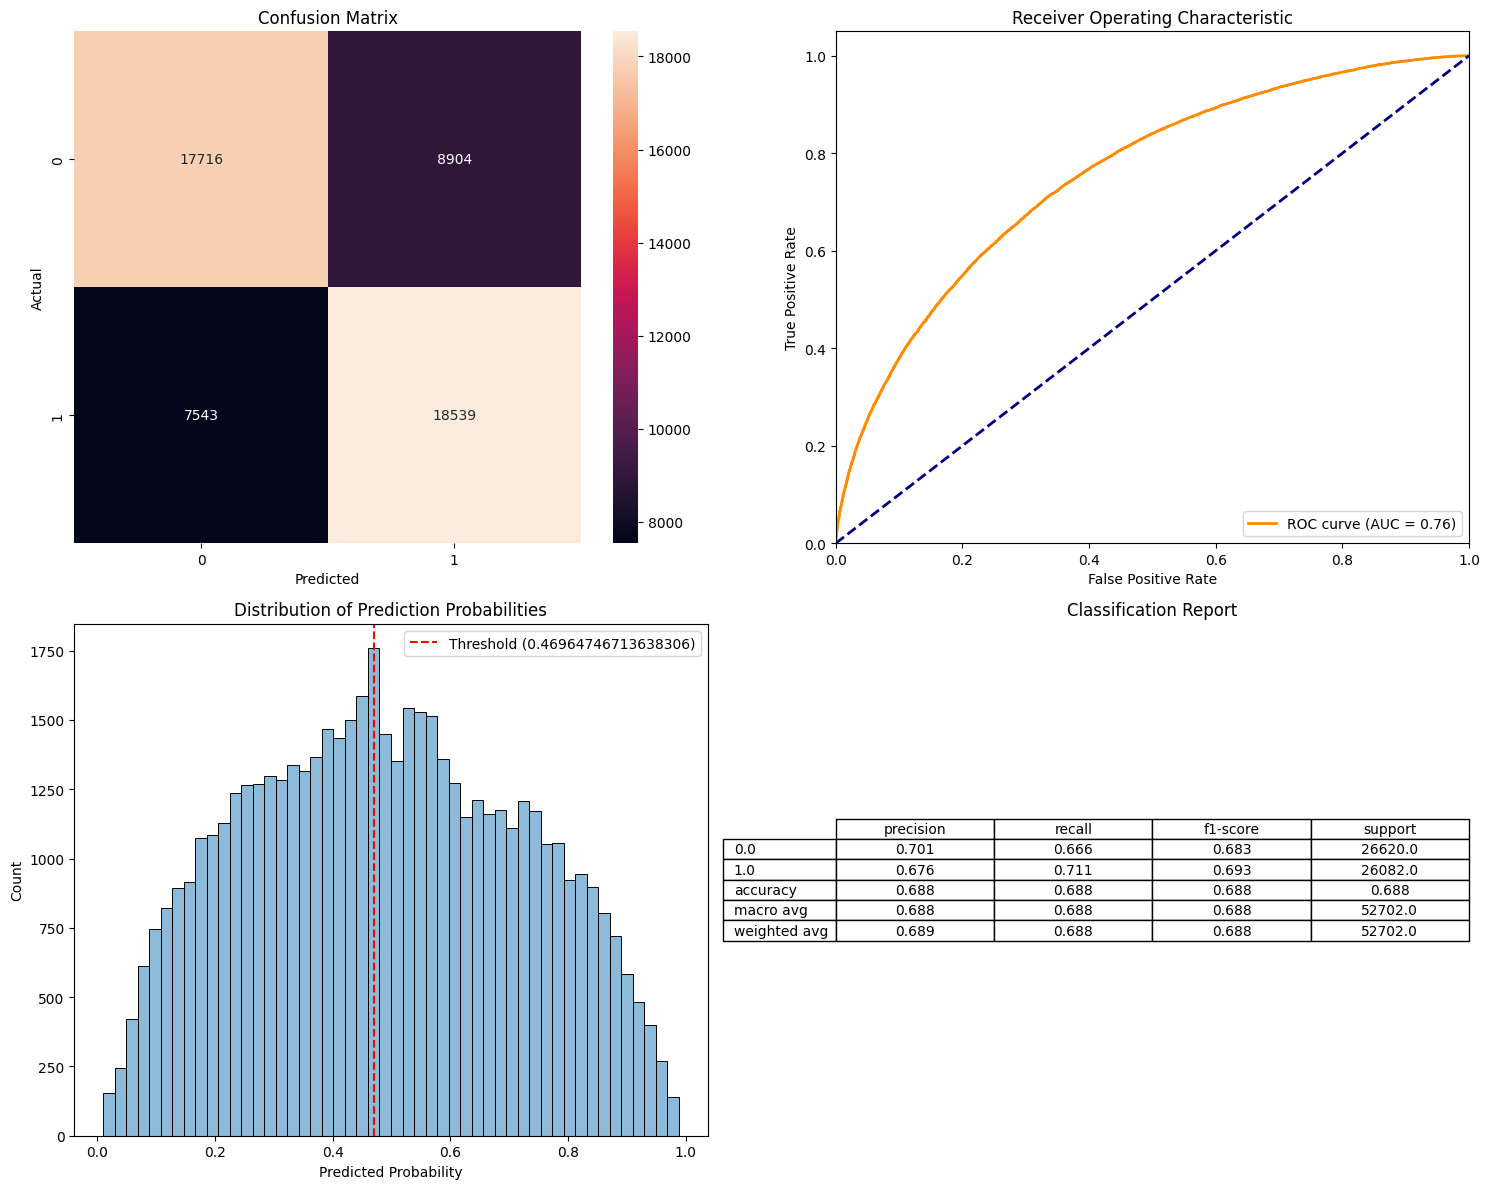


3. Analyzing prediction errors...
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step


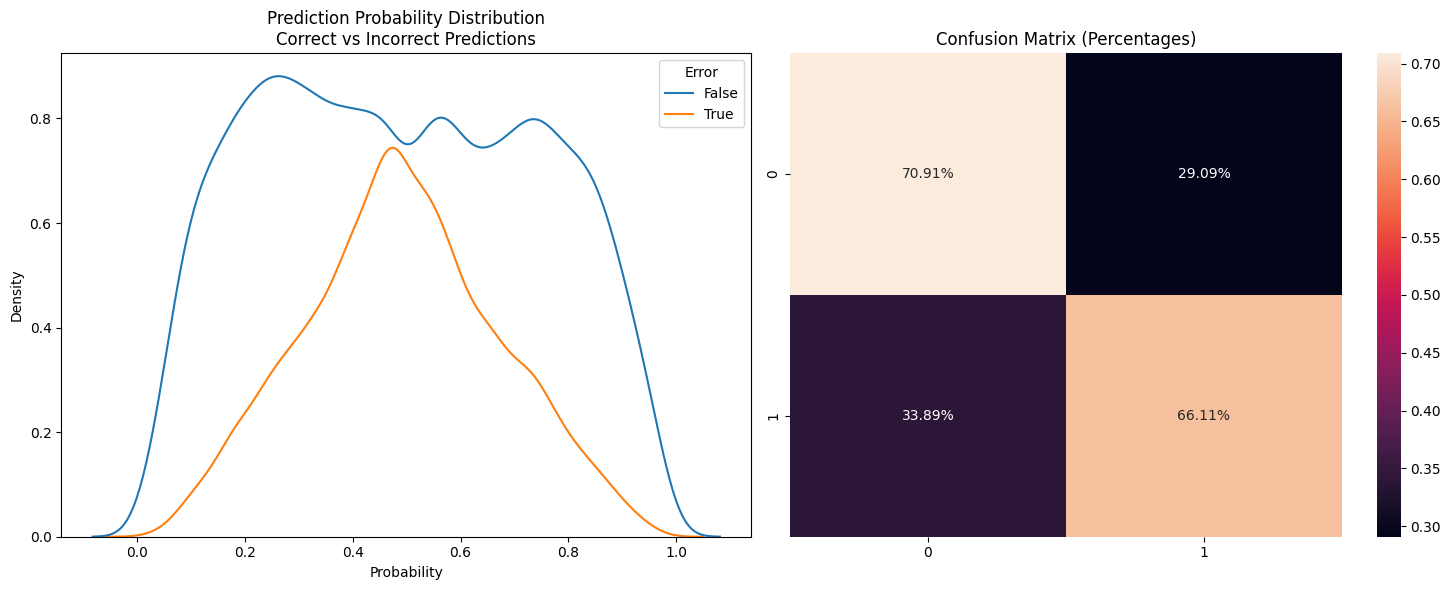


4. Evaluating prediction horizons...
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step


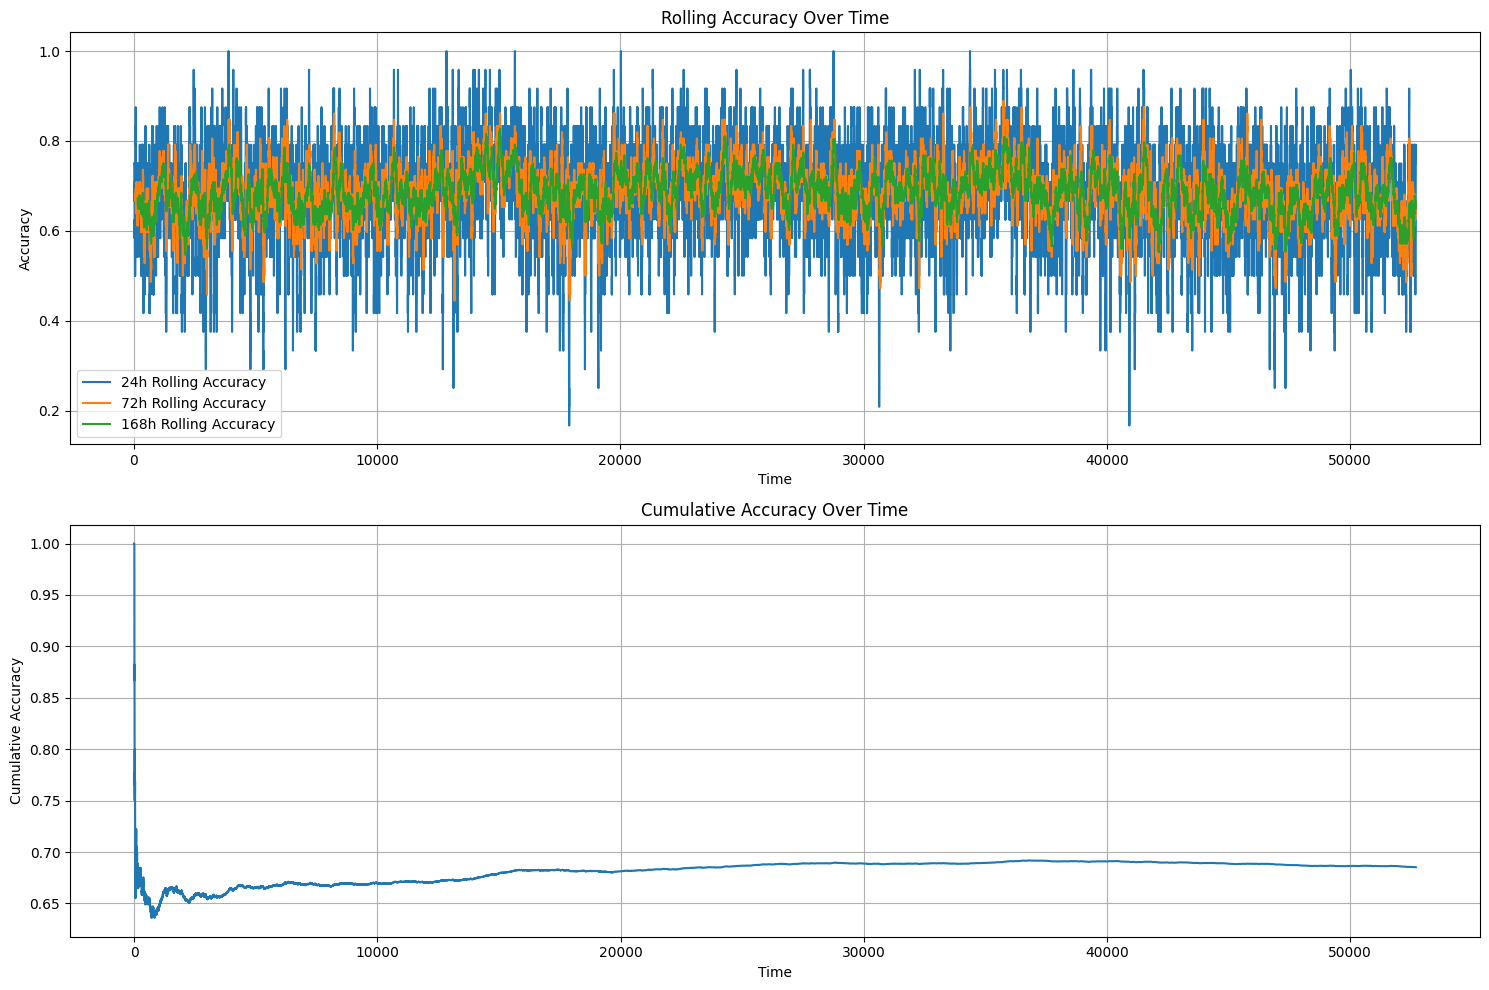

In [60]:
# Get input shape from training data
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
        
# Train model
lstm_model, history = train_model(X_train_seq,
                                  y_train_seq,
                                  X_val_seq, 
                                  y_val_seq,
                                  input_shape,
                                  filepath, 
                                  best_params,
                                  epochs)

# Evaluate on test set
test_results = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=1)
print("\nTest results:")
for metric, value in zip(lstm_model.metrics_names, test_results):
    print(f"-----------> {metric}: {value:.4f}")
    mlflow.log_metric(metric, value)

# get train predictions
target_train_pred = lstm_model.predict(X_train_seq)
optimal_train_treshold = get_optimal_treshold(y_train_seq, target_train_pred)
target_train_pred = (target_train_pred > optimal_train_treshold).astype(int)

# get test predictions
target_test_pred = lstm_model.predict(X_test_seq)
get_optimal_treshold(y_test_seq, target_test_pred)
target_test_pred = (target_test_pred > 0.5).astype(int)

# Validate
classification_train_report = classification_report(y_train_seq, target_train_pred)
classification_test_report = classification_report(y_test_seq, target_test_pred)

print(f"\ntrain_classification_report_{model_type}: \n", classification_train_report)
print(f"\ntest_classification_report_{model_type}: \n", classification_test_report)

# Analysis results
analysis_results = perform_complete_analysis(lstm_model, X_test_seq, y_test_seq, btc_price_data_1_year, history, scaler)

#### 8.2.2. Evaluation

#### Classification Report Evaluation

1. **Train Classification Report**

|              |precision| recall | f1-score |support | 
|:------------:|:-------:|:--------:|:-------:|:------:|
|     0        | 0.74   | 0.75     | 0.74    | 211554 |   
|     1        | 0.74   | 0.74     | 0.74    | 210142 |   
| accuracy     |        |          | 0.74    | 421696 |   
| macro avg    | 0.74   | 0.74     | 0.74    | 421696 |   
| weighted avg | 0.74   | 0.74     | 0.74    | 421696 |   

2. **Test Classification Report**

|              |precision| recall | f1-score |support | 
|:------------:|:-------:|:--------:|:-------:|:------:|
|     0        |  0.68   | 0.71     | 0.69    | 211554 |   
|     1        | 0.69    | 0.66     | 0.68    | 210142 |   
| accuracy     |         |          | 0.69    | 421696 |   
| macro avg    | 0.69    | 0.69     | 0.69    | 421696 |   
| weighted avg | 0.69    | 0.69     | 0.69    | 421696 |   

##### Classification Report Metrics

1. **Precision**
    - **Definition**: Precision measures the accuracy of positive predictions. It tells us what proportion of predicted positive instances are actually positive.
    - **Interpretation**: High precision indicates that the model is making very few false positive errors.
    - **Formula**: $$\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}$$

2. **Recall (Sensitivity or True Positive Rate)**
    - **Definition**: Recall measures the ability of the model to capture all positive instances. It tells us what proportion of actual positive instances were correctly identified.
    - **Interpretation**: High recall indicates that the model captures most of the positive instances.
    - **Formula**:  $$\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}$$

3. **F1-Score**
    - **Definition**: The F1-score is the harmonic mean of precision and recall. It provides a single metric that balances the trade-off between precision and recall.
    - **Interpretation**: A high F1-score indicates a good balance between precision and recall. It is particularly useful when the class distribution is imbalanced.
    - **Formula**: $$\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

4. **Support**
    - **Definition**: Support is the number of actual occurrences of each class in the dataset. It indicates the size of the ground truth data for each class.
    - **Interpretation**: While support is not a performance metric, it helps in understanding how many instances belong to each class, which is essential for analyzing model performance in the context of imbalanced datasets.

##### Analysis of the Reports

**1. Training Data (train_classification_report_LSTM):**

* The model performs relatively well on the training data, achieving an accuracy of 74%.
* Precision, recall, and F1-score are consistent across both classes (0.0 and 1.0), indicating a balanced performance.
* This indicates that the model has learned patterns within the training data.
* However, 74% accuracy, while not terrible, also indicates that the model is not capturing all the patterns in the training data. There is room for improvement.

**2. Test Data (test_classification_report_LSTM):**

* The model's performance drops on the test data, with an accuracy of 69%.
* This decrease in performance suggests that the model is overfitting to the training data.
* The precision, recall, and F1-score are also lower than in the training set, confirming the drop in performance.
* The performance difference between the training and test sets suggests a generalization gap. The model is less accurate on unseen data.

##### Key Observations and Potential Issues
* **Overfitting**: There's a 5% drop in accuracy from training (74%) to test (69%), indicating some overfitting.
* **Class Imbalance in Performance**: While the dataset is balanced in terms of samples, there's a slight imbalance in model performance between classes:
   - Class 0 has better recall (0.71) than Class 1 (0.66)
   - Class 1 has slightly better precision (0.69) than Class 0 (0.68)
* **Overall Performance**: The model shows moderate performance with metrics in the high 60s to low 70s range, which may or may not be satisfactory depending on your application.

#### Confusion Matrix Analysis
- **True Positives**: 18,539 (Class 1 correctly predicted)
- **True Negatives**: 17,716 (Class 0 correctly predicted)
- **False Positives**: 8,904 (Class 0 incorrectly predicted as Class 1)
- **False Negatives**: 7,543 (Class 1 incorrectly predicted as Class 0)
- **Current Decision Threshold**: 0.47, slightly lower than the standard 0.5

#### ROC Curve Assessment
- **AUC (Area Under Curve)**: 0.76
- This indicates moderate discriminative ability – substantially better than random classification (0.5) but below excellent performance (>0.9)
- The curve shows consistent performance advantage over random classification across all threshold values

##### Overall Performance Assessment
1. **Balanced Accuracy**: With 17,716 + 18,539 = 36,255 correct predictions out of 52,702 total samples, the balanced accuracy is approximately 68.8% (consistent with your previous report)

2. **Threshold Selection**: The current threshold (0.47) suggests some optimization has already been done to balance precision and recall

3. **Model Quality**: An AUC of 0.76 indicates a model with decent predictive power, but there's room for improvement

4. **Classification Errors**: There's a fairly balanced distribution of errors between false positives (8,904) and false negatives (7,543)

## 9. Final Thoughts

### Conclusion
Time series forecasting is a crucial tool across various industries, helping businesses, governments, and researchers make data-driven decisions. With the rise of AI and deep learning, forecasting accuracy has significantly improved, making it an essential part of modern analytics.

In this project, we explored deep learning models to predict Bitcoin market movements.  

The implemented CNN-LSTM model generates buy/sell signals using technical indicators. The model exhibits slight overfitting, with a 5% performance drop from training to testing. Classification errors are fairly balanced between false positives and false negatives, and the decision threshold was fine-tuned slightly below the standard 0.5. While the model demonstrates moderate predictive power, there is room for improvement. Performance metrics (accuracy ~69%, AUC 0.76) indicate reasonable but not exceptional discriminative ability.  

This hybrid CNN-LSTM approach shows promise but could benefit from further refinement through regularization, architectural adjustments, or feature engineering to enhance predictive performance. 

### Further improvements

To further improve the performance of the model, you could do the following:

* **Regularization:** Consider changes to regularization techniques such as L1 or L2 regularization, dropout, or batch normalization to reduce overfitting.
* **Data Augmentation:** Augment the training data to increase its diversity and reduce overfitting.
* **Hyperparameter Tuning:** Experiment with different hyperparameters for the CNN and LSTM layers, such as the number of filters, kernel sizes, LSTM units, and learning rate.
* **More Data:** Obtain more training data to help the model learn more robust patterns.
* **Model Architecture:** Consider changes to the model architecture. perhaps a simpler or more complex architecture could yield better results.
* **Cross-Validation:** Use k-fold cross-validation to get a more reliable estimate of the model's performance.

## Resources

[1] O’Shea, K., & Nash, R. (2015, November 26). An introduction to convolutional neural networks. arXiv.org. https://arxiv.org/abs/1511.08458

[2] Ho, S., chreiter, Fakultat f ur Informatik, Schmidhub, J., er, & IDSIA. (1997). LONG SHORT-TERM MEMORY. Neural Computation, 9(8), 1735–1780. https://www.bioinf.jku.at/publications/older/2604.pdf

[3] Venujkvenk. (2023b, September 23). Exploring time series data: unveiling trends, seasonality, and residuals. Medium. https://medium.com/venujkvenk/exploring-time-series-data-unveiling-trends-seasonality-and-residuals-5cace823aff1

[4] Kis, A. (2024, November 19). Understanding autocorrelation and partial autocorrelation functions (ACF and PACF). Medium. https://medium.com/kis.andras.nandor/understanding-autocorrelation-and-partial-autocorrelation-functions-acf-and-pacf-2998e7e1bcb5

[5] Olamendy, J. C. (2025, January 17). Mastering feature scaling and normalization in machine learning. Medium. https://medium.com/juanc.olamendy/mastering-feature-scaling-and-normalization-in-machine-learning-985fdecfab5c

[6] Hamad, R. (2023, December 11). What is LSTM? Introduction to Long Short-Term Memory. Medium. https://medium.com/rebeen.jaff/what-is-lstm-introduction-to-long-short-term-memory-66bd3855b9ce